# Boston Housing Price Prediction: Exploratory Data Analysis

The purpose of this notebook is to explore the features associated with the Boston housing dataset that is a popular dataset for learning linear regression and can be found here: https://www.kaggle.com/vikrishnan/boston-house-prices

Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository1): CRIM: per capita crime rate by town

    RM: average number of rooms per dwelling
    PTRATIO: pupil-teacher ratio by town 12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town 13. 
    LSTAT: % lower status of the population
    MEDV: Median value of owner-occupied homes in 1000s(USD)

We can see that the input attributes have a mixture of units.

This notebook will use EDA to perform feature selection for this regression problem.

Linear regression will be tried as well as using L1 (lasso) regularization, L2 (ridge) regularization, and Elastic Net to check how to avoid overfitting

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# import the dataset
boston_df = pd.read_csv('boston_housing.csv')
boston_df.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


## Exploratory Data Analysis

In [11]:
boston_df.shape

(489, 4)

In [12]:
boston_df.describe()

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


### Analysis:
The RM feature seems like it should not have a float value for the min nor the max since it rooms are a discrete number.

The max of percent lower status is 37.97% which means there is a neighborhood with a lot of low income residents.

The pupil teacher ratio looks reasonable as it ranges from 12 pupils per teacher to 22 pupils per teacher

### Look for missing data

In [13]:
boston_df.isna().sum()

RM         0
LSTAT      0
PTRATIO    0
MEDV       0
dtype: int64

No missing data in this dataset

## Look for Outliers

### Rooms (RM)

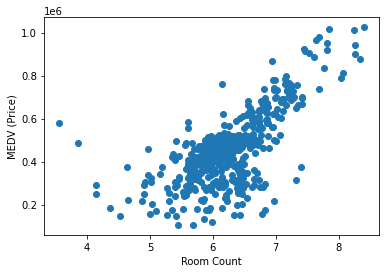

In [43]:
# plot a scatter plot for Rooms and MEDV
plt.scatter(x=boston_df['RM'],y=boston_df['MEDV'])
plt.ylabel('MEDV (Price)')
plt.xlabel('Room Count')
plt.show()


### Looks like removing a few outliers will create a very clear relationship between number of rooms and price

To remove the outliers, use 1.5 times the Inter Quartile Range above the third quartile or below the first quartile.


In [50]:
rm_data = boston_df['RM']

#calculate interquartile range 
q3, q1 = np.percentile(rm_data, [75 ,25])

# calculate the IQR
iqr = q3 - q1

# define outliers
lower_range = q1 - (1.5*iqr)
upper_range = q3 + (1.5*iqr)

print(f'The lower range of outlier is {lower_range} and the upper range of outlier is {upper_range}')


The lower range of outlier is 4.8374999999999995 and the upper range of outlier is 7.617500000000001


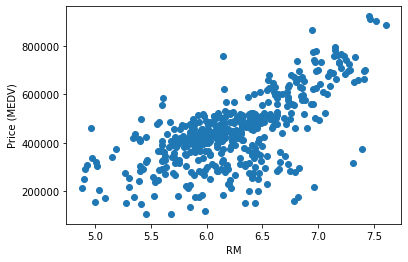

In [54]:
no_low_outlier = boston_df[boston_df['RM'] >= lower_range]
no_outliers_df = no_low_outlier[no_low_outlier['RM'] <= upper_range]

plt.scatter(x=no_outliers_df['RM'], y=no_outliers_df['MEDV'])
plt.xlabel('RM')
plt.ylabel('Price (MEDV)')
plt.show()

In [58]:
# calculate the percentage of data removed 
percent_removed = (boston_df.shape[0] - no_outliers_df.shape[0]) / boston_df.shape[0]

print(percent_removed)

no_outliers_df.shape, boston_df.shape

0.044989775051124746


((467, 5), (489, 5))

### This removed 22 data points or 4.5% of the data

This seems like a significant amount of data to remove but will be worth trying to compare model results.

Instead it seems better to simply remove the data points where RM is less than 4

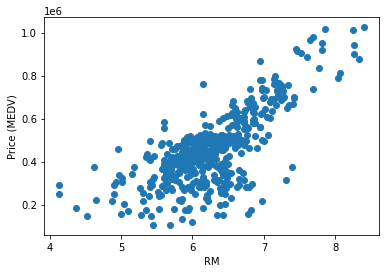

In [59]:
remove_two_outliers = boston_df[boston_df['RM'] >= 4]

plt.scatter(x=remove_two_outliers['RM'], y=remove_two_outliers['MEDV'])
plt.xlabel('RM')
plt.ylabel('Price (MEDV)')
plt.show()

## Percent of Lower Status (LSTAT)

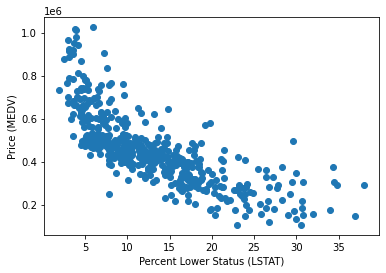

In [33]:
# look at the scatter plot of percent lower status and MEDV
plt.scatter(x=boston_df['LSTAT'], y=boston_df['MEDV'])
plt.xlabel('Percent Lower Status (LSTAT)')
plt.ylabel('Price (MEDV)')
plt.show()

### Does not look exactly linear, looks almost like an inverse relationship (y = 1/x)
LSTAT may need a transformation to get the optimal fit

There do not seem to be many outliers. Perhaps a data point at around LSTAT 29 and MEDV 0.5 can be removed

In [65]:
# find the data point around LSTAT 29 and MEDV 0.5
boolean_1 = (boston_df['LSTAT'] > 27)&(boston_df['LSTAT'] < 31)
first_filter_df = boston_df[boolean_1]
second_filter_df = first_filter_df[first_filter_df['MEDV'] > 0.4].sort_values(by='MEDV', ascending=False)
second_filter_df

,RM,LSTAT,PTRATIO,MEDV,PricePerRoom
207,5.412,29.55,18.6,497700.0,91962.305987
148,5.186,28.32,14.7,373800.0,72078.673351
8,5.631,29.93,15.2,346500.0,61534.363346
126,5.613,27.26,19.1,329700.0,58738.642437
147,4.926,29.53,14.7,306600.0,62241.169306
48,5.399,30.81,17.9,302400.0,56010.372291
145,6.130,27.80,14.7,289800.0,47275.693312
32,5.950,27.71,21.0,277200.0,46588.235294
144,4.903,29.29,14.7,247800.0,50540.485417
369,4.652,28.28,20.2,220500.0,47398.968186


### The outlier is at index 207. That row can be removed.

In [66]:
lstat_filtered_df = boston_df.drop(index=207, axis=0)
boston_df.shape, lstat_filtered_df.shape

((489, 5), (488, 5))

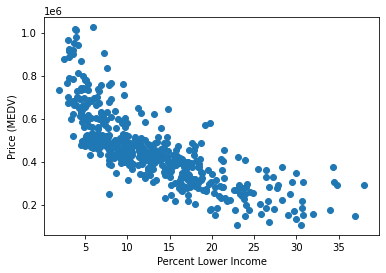

In [67]:
# plot the new dataframe MEDV vs LSTAT
plt.scatter(x=lstat_filtered_df['LSTAT'], y=lstat_filtered_df['MEDV'])
plt.xlabel('Percent Lower Income')
plt.ylabel('Price (MEDV)')
plt.show()


### Removing the one data point makes the relationship look better

## PTRATIO

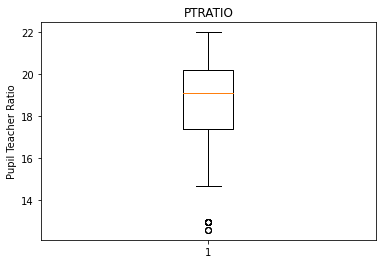

In [30]:
# look at boxplot for Parent Teacher Ratio
plt.boxplot(boston_df['PTRATIO'])
plt.title('PTRATIO')
plt.ylabel('Pupil Teacher Ratio')
plt.show()

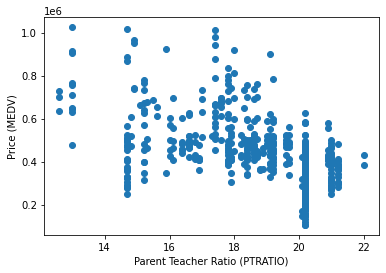

In [34]:
# look at a scatter plot of Parent Teacher Ratio and MEDV
plt.scatter(x=boston_df['PTRATIO'], y=boston_df['MEDV'])
plt.xlabel('Parent Teacher Ratio (PTRATIO)')
plt.ylabel('Price (MEDV)')
plt.show()

### There is not a strong relationship between parent teacher ratio and price
One interesting analysis is whether you adjust for the number of rooms of the house you get a clearer relationship.

Try dividing the price of the house by the number of rooms and plot versus the Parent Teacher Ratio

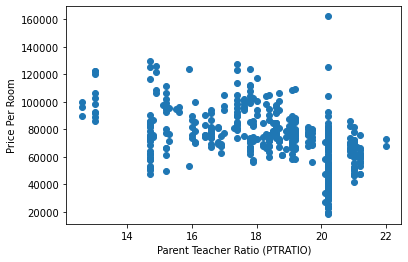

In [68]:
# divide the price by the number of rooms
boston_df['PricePerRoom'] = boston_df['MEDV'] / boston_df['RM']

plt.scatter(x=boston_df['PTRATIO'], y=boston_df['PricePerRoom'])
plt.ylabel('Price Per Room')
plt.xlabel('Parent Teacher Ratio (PTRATIO)')
plt.show()

### A linear relationship is slightly more apparent, but there are some outliers.
This may not be a good feature for predicting housing price. If it is used at all, it should only have a small impact.

## Remove the extreme outlier from the PTRATIO

The outlier of interest is between 20-21 PTRATIO and 160000

In [70]:
# filter the dataset
boston_df[boston_df['PricePerRoom'] > 150000]

,RM,LSTAT,PTRATIO,MEDV,PricePerRoom
353,3.561,7.12,20.2,577500.0,162173.546757


In [71]:
# drop the value at index 353
price_per_room_filtered = boston_df.drop(index=353, axis=0)
price_per_room_filtered.shape, boston_df.shape

((488, 5), (489, 5))

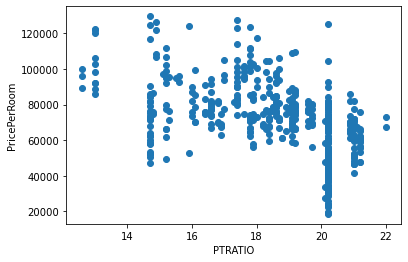

In [72]:
plt.scatter(x=price_per_room_filtered['PTRATIO'], y=price_per_room_filtered['PricePerRoom'])
plt.xlabel('PTRATIO')
plt.ylabel('PricePerRoom')
plt.show()

### This now fits into a narrower range and looks to have a slight negative correlation with price per room

## Final Outlier Analysis:

It will good for comparison of how the model performs to test the full dataset and a dataset that removes the oultiers of the rooms, the one outlier from the LSTAT, and the one outlier from the PTRATIO

Take the RM filtered dataset and remove index values 207 and 353, if they are not already removed from the previous filtering

In [80]:
# check for the indices in the RM filtered dataframe no_outliers_df
print('Is index 207 in the no_outliers_df?')
print(207 in no_outliers_df.index)
print('\nIs index 353 in the no_outliers_df?')
print(353 in no_outliers_df.index)

Is index 207 in the no_outliers_df?
True

Is index 353 in the no_outliers_df?
False


In [81]:
# drop the index 207
no_outliers_boston_df = no_outliers_df.drop(index=207, axis=0)
no_outliers_boston_df.shape, boston_df.shape

((466, 5), (489, 5))

In [82]:
# the dataframe to csv
no_outliers_boston_df.to_csv('no_outliers_boston.csv', index=False)